<a href="https://colab.research.google.com/github/refaaksi/Sentiment-Classification-on-Amazon-Reviews/blob/main/NLP_Amazon_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil
import os
from google.colab import drive
import tensorflow as tf
drive.mount('/content/drive')

cwd = os.getcwd()

shutil.copy("drive/MyDrive/Kaggle/kaggle.json",cwd)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/kaggle.json'

In [2]:
#Mengecek apakah tersedia TPU
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

print('Available TPUs: ', len(tf.config.list_logical_devices('TPU')))

Available TPUs:  0


In [3]:
#Menjalankan kaggle API
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Mendownload dataset Amazon reviews di kaggle
! kaggle datasets download bittlingmayer/amazonreviews

!unzip -q amazonreviews.zip

In [6]:
import bz2

train_file = bz2.BZ2File('train.ft.txt.bz2')
test_file = bz2.BZ2File('test.ft.txt.bz2')

train_file = train_file.readlines()
test_file = test_file.readlines()

In [8]:
# Hanya 10% data yang digunakan untuk melakukan training dan test
pct = 0.1
num_train = int(len(train_file)*pct) 
num_test = int(len(test_file)*pct) 

In [33]:
# Membagi dataset menjadi train, validation, dan test
train_set = [x.decode('utf-8') for x in train_file[:num_train]]
val_set = [x.decode('utf-8') for x in train_file[num_train:num_train*2]]
test_set = [x.decode('utf-8') for x in test_file[:num_test]]

In [10]:
# Memisahkan antara kalimat dengan label, serta melakukan preprosessing berupa lowercase
train_labels = [0 if x.split(' ',1)[0] == '__label__1' else 1 for x in train_set[:]]
train_sentences = [x.split(' ', 1)[1][:-1].lower() for x in train_set[:]]

val_labels = [0 if x.split(' ',1)[0] == '__label__1' else 1 for x in val_set[:]]
val_sentences = [x.split(' ', 1)[1][:-1].lower() for x in val_set[:]]

test_labels = [0 if x.split(' ',1)[0] == '__label__1' else 1 for x in test_set[:]]
test_sentences = [x.split(' ', 1)[1][:-1].lower() for x in test_set[:]]

In [12]:
# Melakukan filtering untuk menghilangkan url
import re,string
for i in range(len(train_sentences)):
  train_sentences[i] = re.sub(r"([^ ]+(https|www)?\w+\.[a-z]{3}(/[^\s]+)?)", "url", train_sentences[i])

for i in range(len(val_sentences)):
  val_sentences[i] = re.sub(r"([^ ]+(https|www)?\w+\.[a-z]{3}(/[^\s]+)?)", "url", val_sentences[i])

for i in range(len(test_sentences)):
  test_sentences[i] = re.sub(r"([^ ]+(https|www)?\w+\.[a-z]{3}(/[^\s]+)?)", "url", test_sentences[i])

In [11]:
print(train_labels[0])
print(train_sentences[0])

1
stuning even for the non-gamer: this sound track was beautiful! it paints the senery in your mind so well i would recomend it even to people who hate vid. game music! i have played the game chrono cross but out of all of the games i have ever played it has the best music! it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras. it would impress anyone who cares to listen! ^_^


In [13]:
"""
([^ ]+(https|www)?\w+\.[a-z]{3}(/[^\s]+)?) is regex expression to get the url string:

1. [^ ]+        : Returns a match for any character EXCEPT whitespace (+ means it will accept any character taken one or more time, which is not in the list ), this is to get the url string that usually followed after the whitespace. THEN FOLLOWED BY
2. (https|www)? : To get a url that is started with http/s OR www (? mean that this is optional, because no every url is started with http/www). THEN FOLLOWED BY
3. \w+          : To capture one or more (because of +) string character [a-zA-Z]. THEN FOLLOWED BY
4. \.           : a dot usually an url is string followed by dot (\ means to distinguish the dot with regex special characters which is (.) that capture any characters except newline). THEN FOLLOWED BY
5. [a-z]{3}     : any lowercase character from a-z with maximize of 3 characters, this to capture the domain of url (com, net, edu). THEN FOLLOWED BY
6. (/[^s]+)?    : to capture characters "/" followed by any characters EXCEPT the whitespace (/s). ? mean that is optional because some url can end after .com
"""

'\n([^ ]+(https|www)?\\w+\\.[a-z]{3}(/[^\\s]+)?) is regex expression to get the url string:\n\n1. [^ ]+        : Returns a match for any character EXCEPT whitespace (+ means it will accept any character taken one or more time, which is not in the list ), this is to get the url string that usually followed after the whitespace. THEN FOLLOWED BY\n2. (https|www)? : To get a url that is started with http/s OR www (? mean that this is optional, because no every url is started with http/www). THEN FOLLOWED BY\n3. \\w+          : To capture one or more (because of +) string character [a-zA-Z]. THEN FOLLOWED BY\n4. \\.           : a dot usually an url is string followed by dot (\\ means to distinguish the dot with regex special characters which is (.) that capture any characters except newline). THEN FOLLOWED BY\n5. [a-z]{3}     : any lowercase character from a-z with maximize of 3 characters, this to capture the domain of url (com, net, edu). THEN FOLLOWED BY\n6. (/[^s]+)?    : to capture cha

In [14]:
# Inisiasi TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
tpu_strata = tf.distribute.experimental.TPUStrategy(tpu)
BATCH_SIZE = 16* tpu_strata.num_replicas_in_sync

INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Initializing the TPU system: grpc://10.79.241.162:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.241.162:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [15]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

# Melakukan lemmatization
lemmatizer = WordNetLemmatizer()

def lem(data):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t[0], wn.NOUN)) for w,t in nltk.pos_tag(data.split())]))

st_words = stopwords.words()
def stopword(data):
    return(' '.join([w for w in data.split() if W not in st_words]))
with tpu_strata.scope():
  train_sentences = [lem(train_sentences[i]) for i in range(len(train_sentences))]
  val_sentences = [lem(val_sentences[i]) for i in range(len(val_sentences))]
  test_sentences = [lem(test_sentences[i]) for i in range(len(test_sentences))]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
# Menambahkan Start of Sentences Token (sostoken) dan End of Sentences Token (eostoken)
for i in range(len(train_sentences)):
  train_sentences[i] = "<sostoken> " + train_sentences[i] + " <eostoken>"

for i in range(len(val_sentences)):
  val_sentences[i] = "<sostoken> " + val_sentences[i] + " <eostoken>"

for i in range(len(test_sentences)):
  test_sentences[i] = "<sostoken> " + test_sentences[i] + " <eostoken>"

In [17]:
# Mencari kalimat yang paling panjang
num_len = 0
max_len = 0
a = 0
for i in range(len(train_sentences)):
  num_len = len(train_sentences[i].split(" "))
  if num_len > max_len:
    max_len = num_len
    a = i
print(train_sentences[0].split(" "))

['<sostoken>', 'stun', 'even', 'for', 'the', 'non-gamer:', 'this', 'sound', 'track', 'be', 'beautiful!', 'it', 'paint', 'the', 'senery', 'in', 'your', 'mind', 'so', 'well', 'i', 'would', 'recomend', 'it', 'even', 'to', 'people', 'who', 'hate', 'vid.', 'game', 'music!', 'i', 'have', 'play', 'the', 'game', 'chrono', 'cross', 'but', 'out', 'of', 'all', 'of', 'the', 'game', 'i', 'have', 'ever', 'play', 'it', 'have', 'the', 'best', 'music!', 'it', 'back', 'away', 'from', 'crude', 'keyboarding', 'and', 'take', 'a', 'fresh', 'step', 'with', 'grate', 'guitar', 'and', 'soulful', 'orchestras.', 'it', 'would', 'impress', 'anyone', 'who', 'care', 'to', 'listen!', '^_^', '<eostoken>']


In [18]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np

# Melakukan tokenization
max_features = 4096

vectorize_layer = TextVectorization(
    standardize ='lower_and_strip_punctuation',
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=max_len)

In [20]:
vectorize_layer.adapt(train_sentences)
x_train = vectorize_layer(train_sentences)
y_train = np.array(train_labels)

x_val = vectorize_layer(val_sentences)
y_val = np.array(val_labels)

x_test = vectorize_layer(test_sentences)
y_test = np.array(test_labels)
x_train[0]

<tf.Tensor: shape=(243,), dtype=int64, numpy=
array([  11, 3608,   78,   15,    2,    1,   10,  137,  259,    3,  355,
          9, 1253,    2,    1,   13,   66,  390,   30,   68,    6,   44,
       1496,    9,   78,    7,  128,   72,  571,    1,  185,  123,    6,
         14,  147,    2,  185,    1, 1498,   20,   45,    8,   29,    8,
          2,  185,    6,   14,  121,  147,    9,   14,    2,   86,  123,
          9,  126,  240,   39, 3804,    1,    5,   99,    4, 1076,  814,
         21,    1,  641,    5, 3520,    1,    9,   44, 1678,  201,   72,
        423,    7,  188,   12,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
     

In [27]:
# Membuat model 
with tpu_strata.scope():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(max_features, 64, input_length= max_len),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation = 'sigmoid')

    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'], loss='binary_crossentropy',steps_per_execution=16)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 243, 64)           262144    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 295,425
Trainable params: 295,425
Non-trainable params: 0
_________________________________________________________________


In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience = 2)

In [29]:
# model fit
history = model.fit(x_train,
                    y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=20,
                    verbose=1,
                    validation_data = (x_val, y_val),
                    callbacks=es) 

Epoch 1/20
2813/2813 [==============================] - 195s 69ms/step - loss: 0.3206 - accuracy: 0.8579 - val_loss: 0.2519 - val_accuracy: 0.8992
Epoch 2/20
2813/2813 [==============================] - 174s 62ms/step - loss: 0.2421 - accuracy: 0.9045 - val_loss: 0.2410 - val_accuracy: 0.9041
Epoch 3/20
2813/2813 [==============================] - 174s 62ms/step - loss: 0.2331 - accuracy: 0.9080 - val_loss: 0.2357 - val_accuracy: 0.9060
Epoch 4/20
2813/2813 [==============================] - 174s 62ms/step - loss: 0.2241 - accuracy: 0.9120 - val_loss: 0.2288 - val_accuracy: 0.9082
Epoch 5/20
2813/2813 [==============================] - 174s 62ms/step - loss: 0.2136 - accuracy: 0.9159 - val_loss: 0.2196 - val_accuracy: 0.9118
Epoch 6/20
2813/2813 [==============================] - 173s 62ms/step - loss: 0.2040 - accuracy: 0.9197 - val_loss: 0.2120 - val_accuracy: 0.9154
Epoch 7/20
2813/2813 [==============================] - 174s 62ms/step - loss: 0.1954 - accuracy: 0.9233 - val_loss: 0

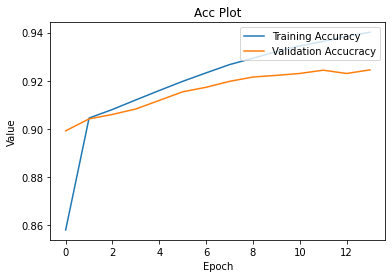

In [30]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#Memplot accuracy data train & validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accucracy')
plt.title('Acc Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

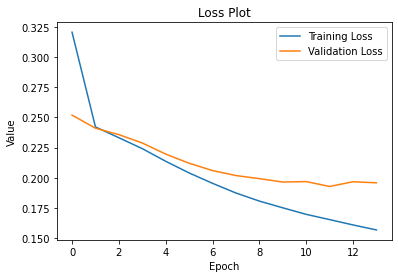

In [31]:
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#Memplot nilai loss data train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [32]:
# Menguji keakuratan model dalam memprediksi data test
model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)

313/313 [==============================] - 3s 10ms/step - loss: 0.2008 - accuracy: 0.9239


[0.20076186954975128, 0.9238749742507935]